A collection of deep learning models in JAX.

*   Author: Tianlin Liu
*   GitHub Repository: https://github.com/liutianlin0121/jax-deep-learning-models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/liutianlin0121/jax-deep-learning-models/blob/main/ConvNet/convnet-cifar-dropout.ipynb)



## Imports

In [1]:
if 'google.colab' in str(get_ipython()):
  %pip install ml-collections -q
  %pip install "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q
  %pip install flax -q

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import ml_collections
import optax

import torchvision
from torch.utils import data

## Prepare the CIFAR-10 dataset

In [3]:
# Helper functions for images.
def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img.squeeze(), cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  if title:
    ax.set_title(title)


def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(2 * n, 2 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)


def numpy_collate(batch):
  """Stack data into a numpy array.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)


class CastAndNormalize(object):
  """Cast and normalize an image.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  def __call__(self, pic):
    return np.array(pic, dtype=jnp.float32) / 255

train_dataset = torchvision.datasets.CIFAR10(
    root='~/torch_datasets', train=True,
    download=True,
    transform=CastAndNormalize())

test_dataset = torchvision.datasets.CIFAR10(
    root='~/torch_datasets', train=False,
    download=True, transform=CastAndNormalize())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

test_images = jnp.array([test_data[0] for test_data in test_dataset])
test_labels = jnp.array([test_data[1] for test_data in test_dataset])

Files already downloaded and verified
Files already downloaded and verified


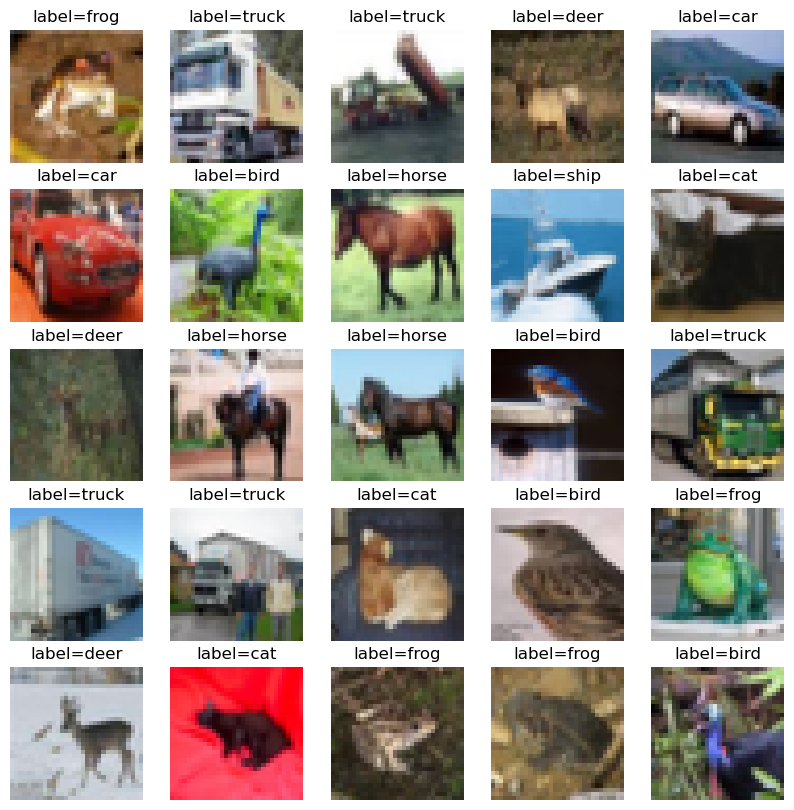

In [4]:
show_img_grid(
  [train_dataset[idx][0] for idx in range(25)],
  [f'label={classes[train_dataset[idx][1]]}' for idx in range(25)],
)


## Set up the model and the training loop

The training loop setup here closely follows the the examples provided in the [flax repository](https://github.com/google/flax/tree/main/examples), sometimes verbatim.



In [5]:
class ConvNet(nn.Module):
  """A ConvNet with dropout."""

  @nn.compact
  def __call__(self, x, training: bool):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)

    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.Dropout(rate=0.5, deterministic=not training)(x)
    x = nn.relu(x)

    x = nn.Dense(features=10)(x)
    return x


@jax.jit
def train_step(state, images, labels, dropout_key):
  """Train on a single batch"""
  def loss_fn(params):
    logits = state.apply_fn(
      {'params': params},
      images,
      training=True,
      rngs={'dropout': dropout_key}
      )
    one_hot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(
      optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return state.apply_gradients(grads=grads), loss, accuracy


def train_epoch(state, train_loader, dropout_key):
  """Train for a single epoch."""

  epoch_loss = []
  epoch_accuracy = []

  for batch_images, batch_labels in train_loader:
    # We use a different dropout key for each batch.
    dropout_key = jax.random.fold_in(key=dropout_key, data=state.step)
    state, loss, accuracy = train_step(
      state, batch_images, batch_labels, dropout_key)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy


class TrainState(train_state.TrainState):
  key: jax.random.KeyArray


def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  rng, params_key, dropout_key = jax.random.split(key=rng, num=3)

  convnet = ConvNet()
  params = convnet.init(
    params_key, jnp.ones([1, 32, 32, 3]), training=False)['params']
  tx = optax.adam(config.learning_rate)

  state = TrainState.create(
    apply_fn=convnet.apply,
    params=params,
    key=dropout_key,
    tx=tx)
  return state


def evaluate_model(state, images, labels):
  logits = state.apply_fn(
    {'params': state.params},
    images,
    training=False,
    rngs={'dropout': jax.random.PRNGKey(0)}
    )

  one_hot = jax.nn.one_hot(labels, 10)
  loss = jnp.mean(
    optax.softmax_cross_entropy(logits=logits, labels=one_hot))

  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return loss, accuracy


def train_and_evaluate(
  config: ml_collections.ConfigDict) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.

  Returns:
    The train state (which includes the `.params`).
  """
  train_loader = data.DataLoader(
    train_dataset, batch_size=config.batch_size,
    shuffle=True, num_workers=4, pin_memory=True,
    collate_fn=numpy_collate, drop_last=True)

  rng = jax.random.PRNGKey(42)

  rng, params_key, dropout_key = jax.random.split(key=rng, num=3)
  state = create_train_state(params_key, config)


  for epoch in range(1, config.num_epochs + 1):
    state, train_loss, train_accuracy = train_epoch(
      state, train_loader, dropout_key)

    test_loss, test_accuracy = evaluate_model(state, test_images, test_labels)

    print(f'epoch: {epoch:02d}/{config.num_epochs:02d} | ' +\
          f'train_loss: {train_loss:.4f} | ' +\
          f'train_accuracy: {train_accuracy * 100: .2f}  | ' +\
          f'test_loss: {test_loss: .4f}  | ' +\
          f'test_accuracy: {test_accuracy * 100:.2f}')

  return state


## Training

In [6]:
config = ml_collections.ConfigDict()

config.learning_rate = 1e-3
config.batch_size = 128
config.num_epochs = 20

state = train_and_evaluate(config)

epoch: 01/20 | train_loss: 1.5511 | train_accuracy:  44.01  | test_loss:  1.1838  | test_accuracy: 57.54
epoch: 02/20 | train_loss: 1.1481 | train_accuracy:  59.74  | test_loss:  0.9736  | test_accuracy: 65.78
epoch: 03/20 | train_loss: 0.9975 | train_accuracy:  65.07  | test_loss:  0.8848  | test_accuracy: 69.22
epoch: 04/20 | train_loss: 0.8858 | train_accuracy:  68.91  | test_loss:  0.9312  | test_accuracy: 67.67
epoch: 05/20 | train_loss: 0.8074 | train_accuracy:  71.68  | test_loss:  0.7982  | test_accuracy: 71.94
epoch: 06/20 | train_loss: 0.7351 | train_accuracy:  74.10  | test_loss:  0.7983  | test_accuracy: 72.58
epoch: 07/20 | train_loss: 0.6753 | train_accuracy:  76.25  | test_loss:  0.7791  | test_accuracy: 73.45
epoch: 08/20 | train_loss: 0.6182 | train_accuracy:  78.30  | test_loss:  0.7909  | test_accuracy: 73.67
epoch: 09/20 | train_loss: 0.5637 | train_accuracy:  79.89  | test_loss:  0.7638  | test_accuracy: 74.75
epoch: 10/20 | train_loss: 0.5279 | train_accuracy:  81

## Inference

In [10]:
# Find all mistakes in testset.
logits = ConvNet().apply({'params': state.params}, test_images, training=False)
error_idxs, = jnp.where(test_labels != logits.argmax(axis=1))
correct_idxs, = jnp.where(test_labels == logits.argmax(axis=1))

print('error rate', len(error_idxs) / len(logits))

error rate 0.2497


### Show some correctly classified digits

Text(0.5, 0.95, 'Examples of correctly classified digits')

<Figure size 640x480 with 0 Axes>

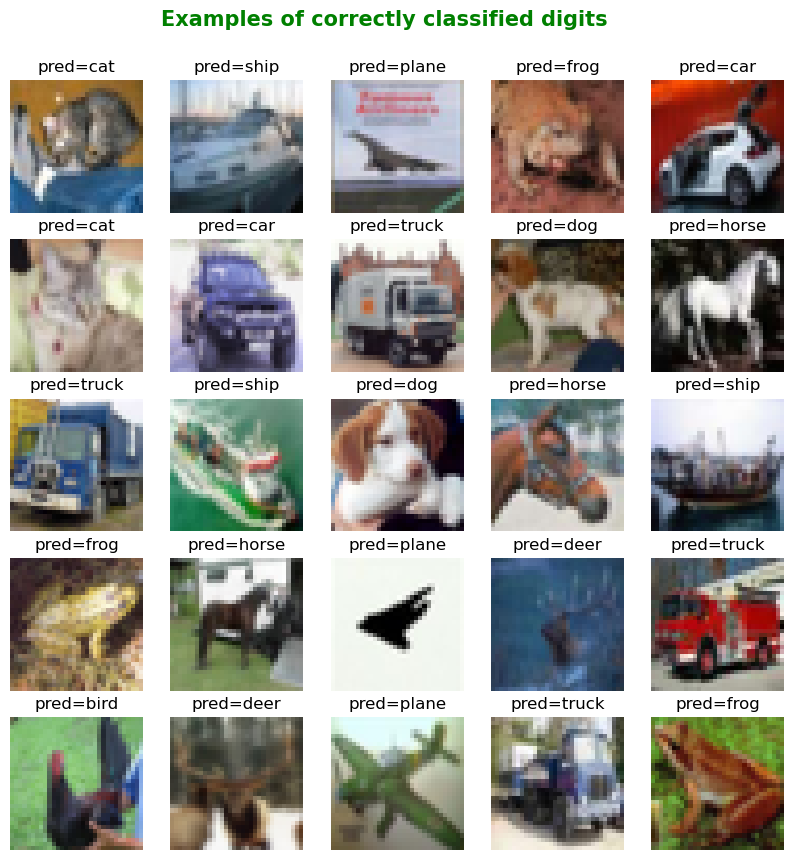

In [8]:
plt.figure()
show_img_grid(
    [test_images[idx] for idx in correct_idxs[:25]],
    [f'pred={classes[logits[idx].argmax()]}' for idx in correct_idxs[:25]],
)
plt.suptitle("Examples of correctly classified digits",
             y=0.95, fontsize=15, c='g', fontweight="bold")

### Show some wrongly classified digits

Text(0.5, 0.95, 'Examples of wrongly classified digits')

<Figure size 640x480 with 0 Axes>

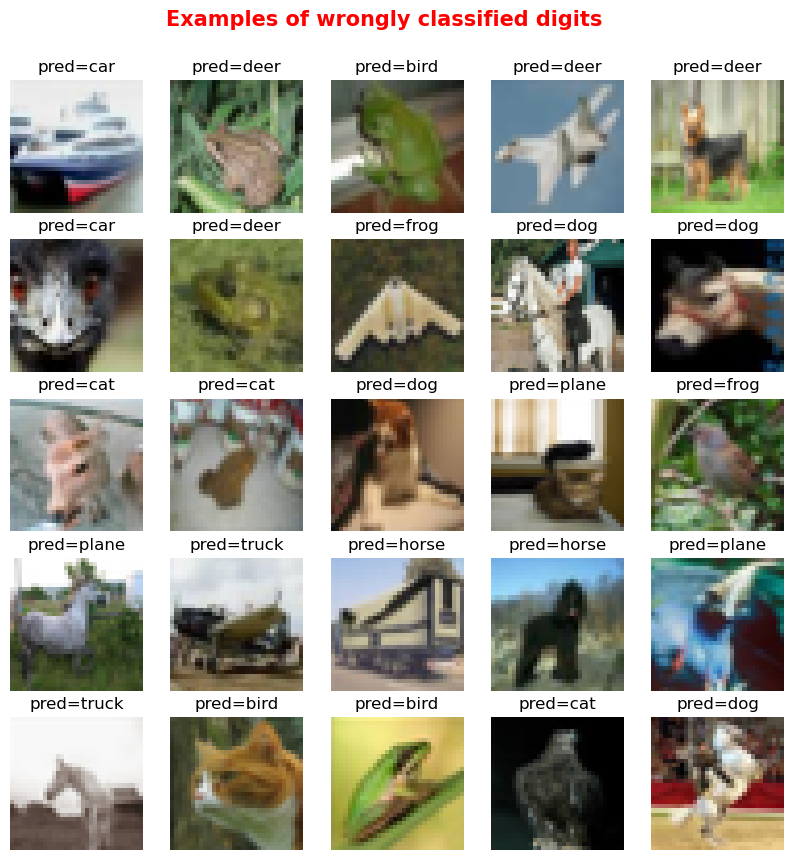

In [9]:
plt.figure()
show_img_grid(
    [test_images[idx] for idx in error_idxs[:25]],
    [f'pred={classes[logits[idx].argmax()]}' for idx in error_idxs[:25]],
)
plt.suptitle("Examples of wrongly classified digits",
             y=0.95, fontsize=15, c='r', fontweight="bold")